 # **Import Library**

In [1]:
# Instalasi semua library yang diperlukan
!pip install pandas numpy scikit-learn matplotlib seaborn gensim tensorflow nltk sastrawi

In [2]:
# Data dan analisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pemrosesan teks
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Visualisasa
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Loading Dataset and Preprocessing**

In [3]:
app_reviews = pd.read_csv('maxim_reviews.csv')
app_reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,6e015e4c-9651-40d5-8bc1-889d0cdaecb4,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Tolong dong, makin ke sini makin ngabisin wakt...",3,0,3.16.9,2025-10-04 01:28:55,NaN,NaN,3.16.9
1,21293bf1-ebdf-4c76-bca9-6ee34fab2900,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"tolong di evaluasi lagi dong, kedepannya untuk...",5,0,3.16.11,2025-10-04 01:20:30,NaN,NaN,3.16.11
2,fc7d6923-77a9-46ba-abb6-db0938b59a70,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,semoga bermanfaat,4,0,3.16.9,2025-10-04 00:54:52,NaN,NaN,3.16.9
3,88336d0a-53fa-4d08-821f-f7f029598a23,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,apasih gak bisa login katanya ngirim kode tapi...,1,0,3.16.11,2025-10-03 23:57:55,NaN,NaN,3.16.11
4,a1dbdd8b-a0bf-4127-b79c-8a399e7a945d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"mohon untuk pihak maxim, tolong dikasih real t...",1,0,3.16.11,2025-10-03 23:20:50,Halo. Mohon maaf atas ketidaknyamanannya. Sara...,2023-12-07 10:24:02,3.16.11


In [4]:
app_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              20000 non-null  object
 1   userName              20000 non-null  object
 2   userImage             20000 non-null  object
 3   content               20000 non-null  object
 4   score                 20000 non-null  int64 
 5   thumbsUpCount         20000 non-null  int64 
 6   reviewCreatedVersion  16764 non-null  object
 7   at                    20000 non-null  object
 8   replyContent          1246 non-null   object
 9   repliedAt             1246 non-null   object
 10  appVersion            16764 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.7+ MB


In [5]:
# Hapus fitur yang tidak dibutuhkan
app_reviews.drop(columns=['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion'], inplace=True)

In [6]:
app_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20000 non-null  object
 1   score    20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [7]:
app_reviews.drop_duplicates(subset = "content", keep= 'first', inplace=True)

In [8]:
app_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12511 entries, 0 to 19998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  12511 non-null  object
 1   score    12511 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 293.2+ KB


In [9]:
def granite_processing(text: str) -> str:
    """
    Processing ringan untuk teks ulasan sebelum dikirim ke IBM Granite.
    - Hapus mention, hashtag, link, simbol asing
    - Pertahankan tanda baca utama (. , ! ?)
    - Konversi ke huruf kecil
    """

    # Hapus mention (@username) dan hashtag
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)

    # Hapus URL
    text = re.sub(r"http\S+|www.\S+", '', text)

    # Hapus karakter selain huruf, angka, spasi, dan tanda baca penting (. , ! ?)
    text = re.sub(r"[^a-zA-Z0-9\s\.\,\!\?]", " ", text)

    # Ganti newline jadi spasi
    text = text.replace("\n", " ")

    # Ubah ke huruf kecil
    text = text.lower()

    # Hapus spasi berlebih
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [10]:
# Terapkan processing ke dataset
app_reviews["clean_content"] = app_reviews["content"].apply(granite_processing)

In [11]:
# Cek hasil
app_reviews.head(10)

,content,score,clean_content
0,"Tolong dong, makin ke sini makin ngabisin wakt...",3,"tolong dong, makin ke sini makin ngabisin wakt..."
1,"tolong di evaluasi lagi dong, kedepannya untuk...",5,"tolong di evaluasi lagi dong, kedepannya untuk..."
2,semoga bermanfaat,4,semoga bermanfaat
3,apasih gak bisa login katanya ngirim kode tapi...,1,apasih gak bisa login katanya ngirim kode tapi...
4,"mohon untuk pihak maxim, tolong dikasih real t...",1,"mohon untuk pihak maxim, tolong dikasih real t..."
5,Jelek banget map nya gak kaya aplikasi yang la...,2,jelek banget map nya gak kaya aplikasi yang la...
6,makin banyak driver yang aneh ga sopan..pernah...,3,makin banyak driver yang aneh ga sopan..pernah...
7,taksi ni kenapa sih masa orderan pada susah ba...,5,taksi ni kenapa sih masa orderan pada susah ba...
8,aplikasi maxwin luar biasa mantap 👍,5,aplikasi maxwin luar biasa mantap
9,oke,5,oke


In [12]:
# Fungsi penggantian kata tidak baku
def replace_taboo_words(text, kamus_tidak_baku):
  if isinstance(text, str):
    words = text.split()
    replaced_words = []
    kalimat_baku = []
    kata_diganti = []
    kata_tidak_baku_hash = []

    for word in words:
        if word in kamus_tidak_baku:
            baku_word = kamus_tidak_baku[word]
            if isinstance(baku_word, str) and all(char.isalpha() for char in baku_word):
                replaced_words.append(baku_word)
                kalimat_baku.append(baku_word)
                kata_diganti.append(word)
                kata_tidak_baku_hash.append(hash(word))
        else:
          replaced_words.append(word)
    replaced_text = ' '.join(replaced_words)
  else:
    replaced_text = ''
    kalimat_baku = []
    kata_diganti = []
    kata_tidak_baku_hash = []

  return replaced_text, kalimat_baku, kata_diganti, kata_tidak_baku_hash

In [13]:
app_reviews.head()

,content,score,clean_content
0,"Tolong dong, makin ke sini makin ngabisin wakt...",3,"tolong dong, makin ke sini makin ngabisin wakt..."
1,"tolong di evaluasi lagi dong, kedepannya untuk...",5,"tolong di evaluasi lagi dong, kedepannya untuk..."
2,semoga bermanfaat,4,semoga bermanfaat
3,apasih gak bisa login katanya ngirim kode tapi...,1,apasih gak bisa login katanya ngirim kode tapi...
4,"mohon untuk pihak maxim, tolong dikasih real t...",1,"mohon untuk pihak maxim, tolong dikasih real t..."


In [14]:
# Baca kamus data tidak baku
kamus_data = pd.read_excel('kamuskatabaku.xlsx')
kamus_tidak_baku = dict(zip(kamus_data['tidak_baku'], kamus_data['kata_baku']))

In [15]:
# Menerapkan fungsi mengganti kata tidak baku
app_reviews['normalisasi'], app_reviews['kata_baku'], app_reviews['kata_tidak_baku'], app_reviews['kata_tidak_baku_hash'] = zip(*app_reviews['clean_content'].apply(lambda x: replace_taboo_words(x, kamus_tidak_baku)))

df = pd.DataFrame(app_reviews)[['score', 'content', 'clean_content', 'normalisasi']]
df.head(10)

,score,content,clean_content,normalisasi
0,3,"Tolong dong, makin ke sini makin ngabisin wakt...","tolong dong, makin ke sini makin ngabisin wakt...","tolong dong, makin ke sini makin ngabisin wakt..."
1,5,"tolong di evaluasi lagi dong, kedepannya untuk...","tolong di evaluasi lagi dong, kedepannya untuk...","tolong di evaluasi lagi dong, kedepannya untuk..."
2,4,semoga bermanfaat,semoga bermanfaat,semoga bermanfaat
3,1,apasih gak bisa login katanya ngirim kode tapi...,apasih gak bisa login katanya ngirim kode tapi...,apasih tidak bisa login katanya mengirim kode ...
4,1,"mohon untuk pihak maxim, tolong dikasih real t...","mohon untuk pihak maxim, tolong dikasih real t...","mohon untuk pihak maxim, tolong dikasih real t..."
5,2,Jelek banget map nya gak kaya aplikasi yang la...,jelek banget map nya gak kaya aplikasi yang la...,jelek banget map ya tidak kayak aplikasi yang ...
6,3,makin banyak driver yang aneh ga sopan..pernah...,makin banyak driver yang aneh ga sopan..pernah...,makin banyak driver yang aneh tidak sopan..per...
7,5,taksi ni kenapa sih masa orderan pada susah ba...,taksi ni kenapa sih masa orderan pada susah ba...,taksi nih kenapa sih masa orderan pada susah b...
8,5,aplikasi maxwin luar biasa mantap 👍,aplikasi maxwin luar biasa mantap,aplikasi maxwin luar biasa mantap
9,5,oke,oke,oke


# **Tokenization and Stopword**

In [16]:
def tokenize(text):
  tokens = text.split()
  return tokens

df['tokenize'] = df['normalisasi'].apply(lambda x: tokenize(x))
df.head()

,score,content,clean_content,normalisasi,tokenize
0,3,"Tolong dong, makin ke sini makin ngabisin wakt...","tolong dong, makin ke sini makin ngabisin wakt...","tolong dong, makin ke sini makin ngabisin wakt...","[tolong, dong,, makin, ke, sini, makin, ngabis..."
1,5,"tolong di evaluasi lagi dong, kedepannya untuk...","tolong di evaluasi lagi dong, kedepannya untuk...","tolong di evaluasi lagi dong, kedepannya untuk...","[tolong, di, evaluasi, lagi, dong,, kedepannya..."
2,4,semoga bermanfaat,semoga bermanfaat,semoga bermanfaat,"[semoga, bermanfaat]"
3,1,apasih gak bisa login katanya ngirim kode tapi...,apasih gak bisa login katanya ngirim kode tapi...,apasih tidak bisa login katanya mengirim kode ...,"[apasih, tidak, bisa, login, katanya, mengirim..."
4,1,"mohon untuk pihak maxim, tolong dikasih real t...","mohon untuk pihak maxim, tolong dikasih real t...","mohon untuk pihak maxim, tolong dikasih real t...","[mohon, untuk, pihak, maxim,, tolong, dikasih,..."


In [17]:
stop_words = stopwords.words('indonesian')

In [18]:
def remove_stopwords(text):
  return [word for word in text if word not in stop_words]

df['stopword_removal'] = df['tokenize'].apply(lambda x: remove_stopwords(x))
df.head()

,score,content,clean_content,normalisasi,tokenize,stopword_removal
0,3,"Tolong dong, makin ke sini makin ngabisin wakt...","tolong dong, makin ke sini makin ngabisin wakt...","tolong dong, makin ke sini makin ngabisin wakt...","[tolong, dong,, makin, ke, sini, makin, ngabis...","[tolong, dong,, ngabisin, waktu., aplikasi, te..."
1,5,"tolong di evaluasi lagi dong, kedepannya untuk...","tolong di evaluasi lagi dong, kedepannya untuk...","tolong di evaluasi lagi dong, kedepannya untuk...","[tolong, di, evaluasi, lagi, dong,, kedepannya...","[tolong, evaluasi, dong,, kedepannya, customer..."
2,4,semoga bermanfaat,semoga bermanfaat,semoga bermanfaat,"[semoga, bermanfaat]","[semoga, bermanfaat]"
3,1,apasih gak bisa login katanya ngirim kode tapi...,apasih gak bisa login katanya ngirim kode tapi...,apasih tidak bisa login katanya mengirim kode ...,"[apasih, tidak, bisa, login, katanya, mengirim...","[apasih, login, mengirim, kode, menerima, kode..."
4,1,"mohon untuk pihak maxim, tolong dikasih real t...","mohon untuk pihak maxim, tolong dikasih real t...","mohon untuk pihak maxim, tolong dikasih real t...","[mohon, untuk, pihak, maxim,, tolong, dikasih,...","[mohon, maxim,, tolong, dikasih, real, time, p..."


In [19]:
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

In [20]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
  return [stemmer.stem(word) for word in text]

df['stemming'] = df['stopword_removal'].apply(lambda x: stem_text(x))
df.head()

,score,content,clean_content,normalisasi,tokenize,stopword_removal,stemming
0,3,"Tolong dong, makin ke sini makin ngabisin wakt...","tolong dong, makin ke sini makin ngabisin wakt...","tolong dong, makin ke sini makin ngabisin wakt...","[tolong, dong,, makin, ke, sini, makin, ngabis...","[tolong, dong,, ngabisin, waktu., aplikasi, te...","[tolong, dong, ngabisin, waktu, aplikasi, tuli..."
1,5,"tolong di evaluasi lagi dong, kedepannya untuk...","tolong di evaluasi lagi dong, kedepannya untuk...","tolong di evaluasi lagi dong, kedepannya untuk...","[tolong, di, evaluasi, lagi, dong,, kedepannya...","[tolong, evaluasi, dong,, kedepannya, customer...","[tolong, evaluasi, dong, depan, customer, waji..."
2,4,semoga bermanfaat,semoga bermanfaat,semoga bermanfaat,"[semoga, bermanfaat]","[semoga, bermanfaat]","[moga, manfaat]"
3,1,apasih gak bisa login katanya ngirim kode tapi...,apasih gak bisa login katanya ngirim kode tapi...,apasih tidak bisa login katanya mengirim kode ...,"[apasih, tidak, bisa, login, katanya, mengirim...","[apasih, login, mengirim, kode, menerima, kode...","[apasih, login, kirim, kode, terima, kode, apapu]"
4,1,"mohon untuk pihak maxim, tolong dikasih real t...","mohon untuk pihak maxim, tolong dikasih real t...","mohon untuk pihak maxim, tolong dikasih real t...","[mohon, untuk, pihak, maxim,, tolong, dikasih,...","[mohon, maxim,, tolong, dikasih, real, time, p...","[mohon, maxim, tolong, kasih, real, time, jemp..."


In [21]:
df.to_csv('maxim_reviews_processing.csv', encoding='utf8', index=False)

# **WordCloud**

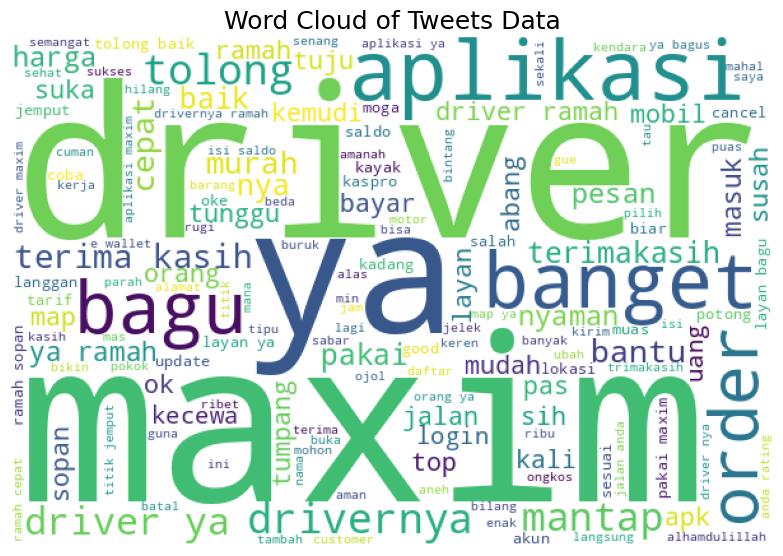

In [22]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'stemming' dari DataFrame 'df'.
for tweet in df['stemming']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Tweets Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

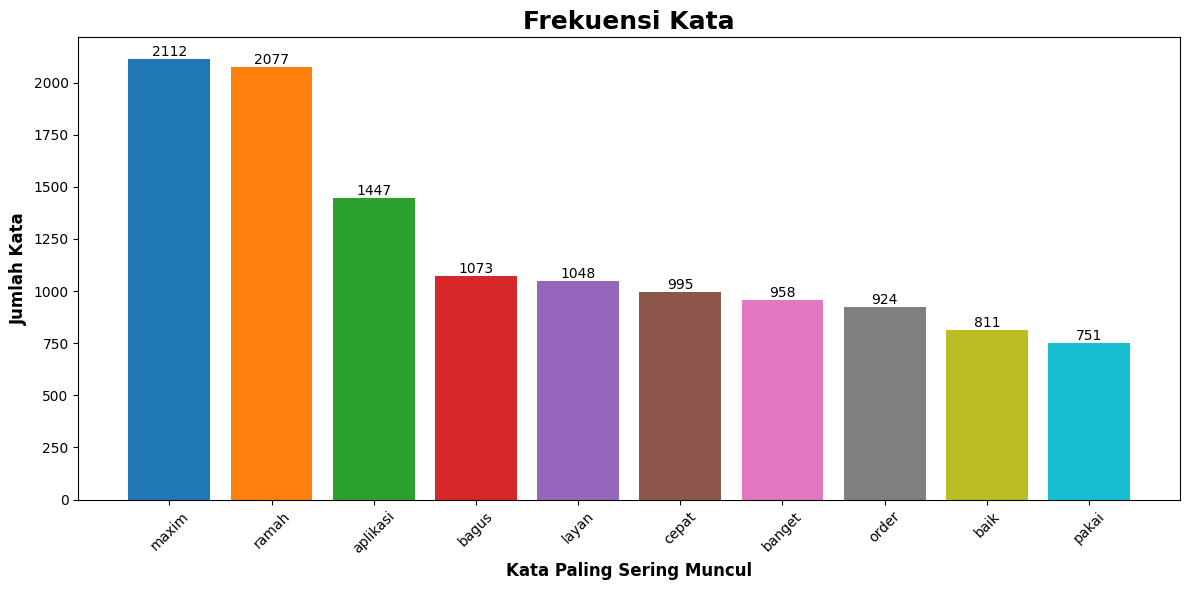

In [23]:
from collections import Counter

# Gabungkan semua teks jadi satu string
text = ' '.join(df['stemming'].astype(str).tolist())

# 🔧 Bersihkan teks: hilangkan tanda baca, angka, emoji, dan ubah ke lowercase
text = re.sub(r'[^\w\s]', '', text.lower())   # hanya biarkan huruf dan spasi
text = re.sub(r'\d+', '', text)               # hapus angka
text = text.strip()

# Stopwords dasar + tambahan
stopwords = set(STOPWORDS)
stopwords.update(['ya', 'pas', 'tolong', 'oke', 'udah', 'harga', 'orderan', 'driver'])

# Tokenisasi sambil buang stopwords
tokens = [t for t in text.split() if t not in stopwords and t != '']

# Hitung frekuensi kata
word_counts = Counter(tokens)
top_words = dict(word_counts.most_common(10))
word, count = zip(*top_words.items())

# Visualisasi
colors = plt.cm.tab10(range(len(word)))
plt.figure(figsize=(12, 6))
bars = plt.bar(word, count, color=colors)
plt.xlabel('Kata Paling Sering Muncul', fontsize=12, fontweight='bold')
plt.ylabel('Jumlah Kata', fontsize=12, fontweight='bold')
plt.title('Frekuensi Kata', fontsize=18, fontweight='bold')
plt.xticks(rotation=45)

# Tampilkan angka di atas bar
for bar, num in zip(bars, count):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(num),
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# **Labelling**

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12511 entries, 0 to 19998
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   score             12511 non-null  int64 
 1   content           12511 non-null  object
 2   clean_content     12511 non-null  object
 3   normalisasi       12511 non-null  object
 4   tokenize          12511 non-null  object
 5   stopword_removal  12511 non-null  object
 6   stemming          12511 non-null  object
dtypes: int64(1), object(6)
memory usage: 781.9+ KB


In [25]:
def determine_sentiment(text):
    # Jika datanya list, ubah dulu ke string
    if isinstance(text, list):
        text = ' '.join(text)

    positive_count = sum(1 for word in text.split() if word in positive_lexicon)
    negative_count = sum(1 for word in text.split() if word in negative_lexicon)

    if positive_count > negative_count:
        return "Positif"
    elif positive_count < negative_count:
        return "Negatif"
    # else:
    #     return None  # netral atau tidak terdeteksi

positive_lexicon = set(pd.read_csv('positive.tsv', sep="\t", header=None)[0])
negative_lexicon = set(pd.read_csv('negative.tsv', sep="\t", header=None)[0])

def replace_none_sentiment(sentiments):
  replace_flag = "Positif"
  for i in range(len(sentiments)):
    if sentiments[i] is None:
      sentiments[i] = replace_flag
      replace_flag = "Negatif" if replace_flag == "Positif" else "Positif"
  return sentiments

df['sentiment'] = df['stemming'].apply(determine_sentiment)
df['sentiment'] = replace_none_sentiment(df['sentiment'].tolist())

df.head(10)

,score,content,clean_content,normalisasi,tokenize,stopword_removal,stemming,sentiment
0,3,"Tolong dong, makin ke sini makin ngabisin wakt...","tolong dong, makin ke sini makin ngabisin wakt...","tolong dong, makin ke sini makin ngabisin wakt...","[tolong, dong,, makin, ke, sini, makin, ngabis...","[tolong, dong,, ngabisin, waktu., aplikasi, te...","[tolong, dong, ngabisin, waktu, aplikasi, tuli...",Negatif
1,5,"tolong di evaluasi lagi dong, kedepannya untuk...","tolong di evaluasi lagi dong, kedepannya untuk...","tolong di evaluasi lagi dong, kedepannya untuk...","[tolong, di, evaluasi, lagi, dong,, kedepannya...","[tolong, evaluasi, dong,, kedepannya, customer...","[tolong, evaluasi, dong, depan, customer, waji...",Negatif
2,4,semoga bermanfaat,semoga bermanfaat,semoga bermanfaat,"[semoga, bermanfaat]","[semoga, bermanfaat]","[moga, manfaat]",Positif
3,1,apasih gak bisa login katanya ngirim kode tapi...,apasih gak bisa login katanya ngirim kode tapi...,apasih tidak bisa login katanya mengirim kode ...,"[apasih, tidak, bisa, login, katanya, mengirim...","[apasih, login, mengirim, kode, menerima, kode...","[apasih, login, kirim, kode, terima, kode, apapu]",Negatif
4,1,"mohon untuk pihak maxim, tolong dikasih real t...","mohon untuk pihak maxim, tolong dikasih real t...","mohon untuk pihak maxim, tolong dikasih real t...","[mohon, untuk, pihak, maxim,, tolong, dikasih,...","[mohon, maxim,, tolong, dikasih, real, time, p...","[mohon, maxim, tolong, kasih, real, time, jemp...",Positif
5,2,Jelek banget map nya gak kaya aplikasi yang la...,jelek banget map nya gak kaya aplikasi yang la...,jelek banget map ya tidak kayak aplikasi yang ...,"[jelek, banget, map, ya, tidak, kayak, aplikas...","[jelek, banget, map, ya, kayak, aplikasi, nya,...","[jelek, banget, map, ya, kayak, aplikasi, nya,...",Positif
6,3,makin banyak driver yang aneh ga sopan..pernah...,makin banyak driver yang aneh ga sopan..pernah...,makin banyak driver yang aneh tidak sopan..per...,"[makin, banyak, driver, yang, aneh, tidak, sop...","[driver, aneh, sopan..pernah, driver, dah, nge...","[driver, aneh, sopan pernah, driver, dah, ngeb...",Negatif
7,5,taksi ni kenapa sih masa orderan pada susah ba...,taksi ni kenapa sih masa orderan pada susah ba...,taksi nih kenapa sih masa orderan pada susah b...,"[taksi, nih, kenapa, sih, masa, orderan, pada,...","[taksi, nih, sih, orderan, susah, banget, mand...","[taksi, nih, sih, order, susah, banget, mandin...",Negatif
8,5,aplikasi maxwin luar biasa mantap 👍,aplikasi maxwin luar biasa mantap,aplikasi maxwin luar biasa mantap,"[aplikasi, maxwin, luar, biasa, mantap]","[aplikasi, maxwin, mantap]","[aplikasi, maxwin, mantap]",Positif
9,5,oke,oke,oke,[oke],[oke],[oke],Positif


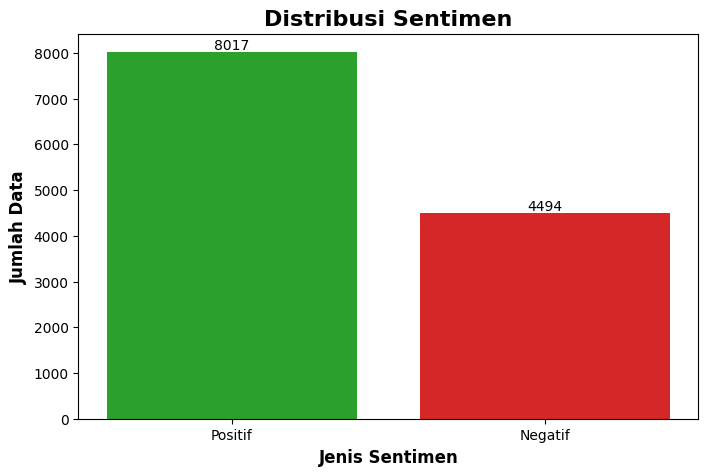

In [26]:
# Hitung jumlah masing-masing label sentimen
sentiment_counts = df['sentiment'].value_counts()

# Visualisasi bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=['tab:green', 'tab:red'])
plt.title('Distribusi Sentimen', fontsize=16, fontweight='bold')
plt.xlabel('Jenis Sentimen', fontsize=12, fontweight='bold')
plt.ylabel('Jumlah Data', fontsize=12, fontweight='bold')

# Tambahkan label jumlah di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10)

plt.show()

In [27]:
df.to_csv('maxim_reviews_labelling.csv', encoding='utf8', index=False)

## Melakukan undersampling untuk menangani bias

In [28]:
# Pisahkan berdasarkan sentimen
df_pos = df[df['sentiment'] == 'Positif']
df_neg = df[df['sentiment'] == 'Negatif']

# Cek jumlah masing-masing
print("Jumlah Positif:", len(df_pos))
print("Jumlah Negatif:", len(df_neg))

# Undersampling: ambil sebanyak jumlah data negatif
df_pos_sampled = df_pos.sample(n=len(df_neg), random_state=42)

# Gabungkan kembali
df_balanced = pd.concat([df_pos_sampled, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

# Cek hasil akhir
print("Jumlah data setelah undersampling:")
print(df_balanced['sentiment'].value_counts())

Jumlah Positif: 8017
Jumlah Negatif: 4494
Jumlah data setelah undersampling:
sentiment
Negatif    4494
Positif    4494
Name: count, dtype: int64


In [29]:
df_balanced.to_csv('maxim_reviews_labelling.csv', encoding='utf8', index=False)

# **Modelling**

In [30]:
data = pd.read_csv('maxim_reviews_labelling.csv')
data.head()

,score,content,clean_content,normalisasi,tokenize,stopword_removal,stemming,sentiment
0,5,seneng,seneng,senang,['senang'],['senang'],['senang'],Negatif
1,5,good person and quikly respons,good person and quikly respons,good person and quikly respons,"['good', 'person', 'and', 'quikly', 'respons']","['good', 'person', 'and', 'quikly', 'respons']","['good', 'person', 'and', 'quikly', 'respons']",Positif
2,4,klo mau buat keluhan terhadap driver gmn ya?,klo mau buat keluhan terhadap driver gmn ya?,kalau mau buat keluhan terhadap driver bagaima...,"['kalau', 'mau', 'buat', 'keluhan', 'terhadap'...","['keluhan', 'driver', 'ya?']","['keluh', 'driver', 'ya']",Positif
3,5,"terima kasih, Ramah dan juga sabar","terima kasih, ramah dan juga sabar","terima kasih, ramah dan juga sabar","['terima', 'kasih,', 'ramah', 'dan', 'juga', '...","['terima', 'kasih,', 'ramah', 'sabar']","['terima', 'kasih', 'ramah', 'sabar']",Positif
4,5,super puas,super puas,super puas,"['super', 'puas']","['super', 'puas']","['super', 'puas']",Positif


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8988 entries, 0 to 8987
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   score             8988 non-null   int64 
 1   content           8988 non-null   object
 2   clean_content     8942 non-null   object
 3   normalisasi       8931 non-null   object
 4   tokenize          8988 non-null   object
 5   stopword_removal  8988 non-null   object
 6   stemming          8988 non-null   object
 7   sentiment         8988 non-null   object
dtypes: int64(1), object(7)
memory usage: 561.9+ KB


In [32]:
# Cek dulu berapa banyak nilai kosong per kolom
print("Jumlah nilai kosong per kolom:")
print(data.isnull().sum())

# Hapus baris yang memiliki nilai kosong di kolom penting
data = data.dropna(subset=['clean_content', 'normalisasi', 'stemming'])

# Reset index setelah menghapus
data = data.reset_index(drop=True)

# Cek kembali hasilnya
print("\nJumlah data setelah menghapus nilai kosong:", len(data))
print(data.isnull().sum())


Jumlah nilai kosong per kolom:
score                0
content              0
clean_content       46
normalisasi         57
tokenize             0
stopword_removal     0
stemming             0
sentiment            0
dtype: int64

Jumlah data setelah menghapus nilai kosong: 8931
score               0
content             0
clean_content       0
normalisasi         0
tokenize            0
stopword_removal    0
stemming            0
sentiment           0
dtype: int64


In [33]:
# membagi dataset menjadi data latih  dan data uji
X_train, X_test, y_train, y_test = train_test_split(data['stemming'], data['sentiment'], test_size=0.2, random_state=42)

In [34]:
# Menyimpan data latih dan data uji
train_set = pd.DataFrame({'text': X_train, 'sentiment': y_train})
train_set.to_csv('train_data.csv', index=False)
test_set = pd.DataFrame({'text': X_test, 'sentiment': y_test})
test_set.to_csv('test_data.csv', index=False)

In [35]:
train_set.head()

,text,sentiment
1470,['cepat'],Negatif
6993,['map'],Positif
6954,"['sumpah', 'ramah', 'poll']",Positif
3994,"['alhamdulillah', 'derita']",Negatif
8473,"['mantul', 'mase']",Positif


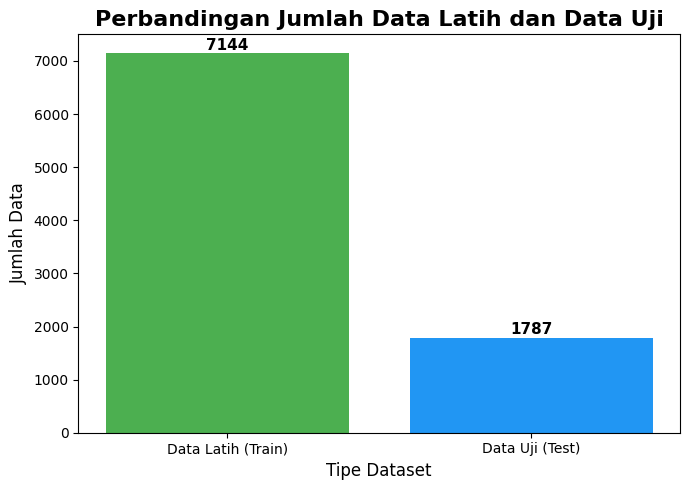

In [36]:
# Hitung jumlah data latih dan data uji
data_split_counts = {
    'Data Latih (Train)': len(X_train),
    'Data Uji (Test)': len(X_test)
}

# Buat bar chart
plt.figure(figsize=(7,5))
plt.bar(data_split_counts.keys(), data_split_counts.values(), color=['#4CAF50', '#2196F3'])

# Tambahkan label dan judul
plt.title('Perbandingan Jumlah Data Latih dan Data Uji', fontsize=16, fontweight='bold')
plt.ylabel('Jumlah Data', fontsize=12)
plt.xlabel('Tipe Dataset', fontsize=12)

# Tambahkan nilai di atas bar
for i, (label, count) in enumerate(data_split_counts.items()):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [37]:
# Vectorisasi teks dengan TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [38]:
# Model SVM
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_tfidf, y_train)

LinearSVC(random_state=42)

In [39]:
# Prediksi data uji
y_pred = svm_model.predict(X_test_tfidf)

In [40]:
# Evaluasi hasil
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

     Negatif       0.79      0.87      0.82       883
     Positif       0.86      0.77      0.81       904

    accuracy                           0.82      1787
   macro avg       0.82      0.82      0.82      1787
weighted avg       0.82      0.82      0.82      1787

Accuracy: 0.8181309457190823


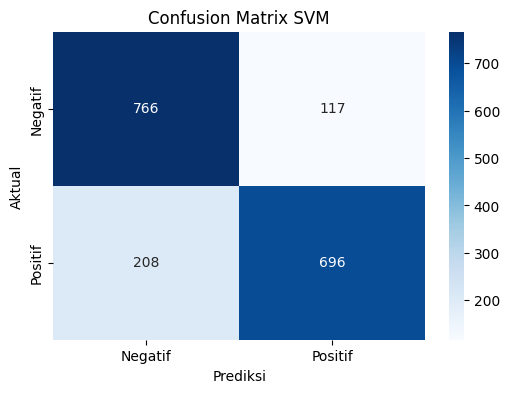

In [41]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix SVM')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

In [42]:
# Pastikan kita ambil data mentah (bukan hasil vectorization sebelumnya)
X_train = train_set['text']
y_train = train_set['sentiment']
X_test = test_set['text']
y_test = test_set['sentiment']

# Lalu lakukan TF-IDF seperti sebelumnya
tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.8,
    sublinear_tf=True,
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [43]:
# Hyperparameter Tuning untuk SVM
param_grid = {
    'C': [0.1, 1, 5, 10],           # regularisasi
    'penalty': ['l2'],              # L2 cocok untuk teks
    'loss': ['hinge', 'squared_hinge']
}

grid_search = GridSearchCV(
    estimator=LinearSVC(random_state=42),
    param_grid=param_grid,
    cv=5,                           # 5-fold cross validation
    scoring='accuracy',
    n_jobs=-1,                      # gunakan semua core CPU
    verbose=2
)

In [44]:
# Training Model
grid_search.fit(X_train_tfidf, y_train)

print("\n=== Best Parameters ===")
print(grid_search.best_params_)

print("\n=== Best Cross-Val Accuracy ===")
print(grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits

=== Best Parameters ===
{'C': 1, 'loss': 'hinge', 'penalty': 'l2'}

=== Best Cross-Val Accuracy ===
0.813689128555551


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [46]:
# Evaluasi pada Data Uji
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_tfidf)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("Accuracy on Test Data:", accuracy_score(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

     Negatif       0.77      0.91      0.83       883
     Positif       0.89      0.73      0.80       904

    accuracy                           0.82      1787
   macro avg       0.83      0.82      0.82      1787
weighted avg       0.83      0.82      0.82      1787

Accuracy on Test Data: 0.8192501398992725


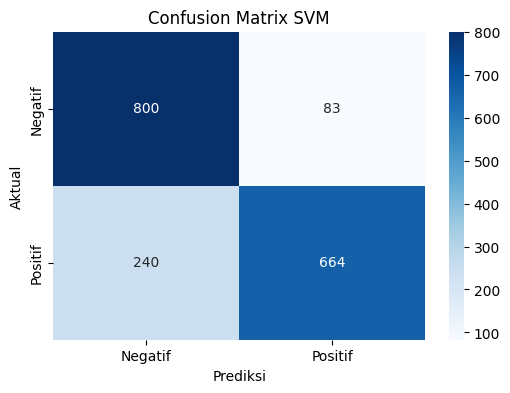

In [47]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix SVM')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()